In [2]:
import numpy as np
import sys
import re
import os
import cygnus_lib as cy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
#import mylib as my
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line, resize, rescale)
import scipy.ndimage
from skimage.transform import hough_circle, hough_circle_peaks
from scipy.stats import norm
import scipy.stats as stats


import pandas as pd
import pickle
import time
from IPython import display

%matplotlib inline
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
plt.rcParams['font.serif'] = ['Bitstream Vera Sans']
x_resolution = y_resolution = 2048
from itertools import combinations

In [13]:
#  Clustering Th VARIABLE!!!

In [11]:
cy.set_atlas_style('large')
############# Data in imput #######################################
dataSelection = 'LAB'

runI = [834, 823, 835, 848, 860, 730]
#runI = [730, 823, 835, 848, 860, 340] # 340, 730, 823, 835, 848, 860
debug  = False
files = ""
################ analysis cards ################################
cimax        = 130       # valori del cut sull'imagine
cminx        = 101
PedMed       = 98.79
iTr          = 0         # traccia di partenza
rescale      = 512       # binnagio finale immagine (deve essre un sottomultipli della 2**2 risluzione di partenza)
minClose     = 4         # minimum cluser size (rebinne image)
maxClose     = 30000     # massima dimesione del clustr evita le scriche      
Cmethod      = 'nccs'    #'hdbs' # 'nccs'
max_image_to_read = 0  # 0 all

############### Inzializzazione varibili e costanti #################
scale        = int(x_resolution/rescale)
SumLight     = SumBck = SumPixel = 0.0
pClose       = 0
pixelCut     = 0
# MAIN LOOP ON 

for nRi in range(0,len(runI)):
    
    max_image=np.size(cy.swift_listdir(cy.file2FullPathCygnus(dataSelection, runI[nRi], 'H5')))
    print ("# of Image Files: %d" % (max_image))
    if max_image_to_read != 0:
        max_image = max_image_to_read   
    print ("WARNING: data will be anlyzed from %d to %d" % (iTr, max_image))

    if max_image == 0:
        print ("No file or image for file %s" % runI[nRi])
        print ("STOP")
        break

    #
    # load pedestal value generated by runs-pedestals.ipynb script
    # 
    try:
        fileoutm = ("./data/run%d_mean.h5" % (runI[nRi]))
        m_image = cy.read_image_h5(fileoutm)
        #################### WARNING ###############
        m_image[:,:]=PedMed 
        PedOverMax = m_image[m_image > cimax].size
        print ("Pedestal mean: %.2f, sigma: %.2f, over th. (%d) %d" % 
           (m_image[m_image<cimax].mean(), 
            np.sqrt(m_image[m_image<cimax].var()), cimax,
            (m_image>cimax).sum()))
    except:
        print ("No Pedestal file for run %s, run script runs-pedestals.ipynb" % runI[nRi])
        print ("STOP")
        break
    try: 
        fileouts = ("./data/run%d_sigma.h5" % (runI[nRi]))
        s_image = cy.read_image_h5(fileouts)
        print ("Sigma mean: %.2f, sigma: %.2f, over th. (10) %d" % 
       (s_image[s_image<10].mean(), 
        np.sqrt(s_image[s_image<10].var()), 
        (s_image>10).sum()))
    except:
        print ("No Sigma file for run %s, run script runs-pedestals.ipynb" % runI[nRi])
        print ("STOP")
        break

        
    #
    # Run by run init 
    #
    th_image[:,:]=cminx # per imostare tutto a 101
    data   = [] # output data 
    TrOk   = 0
    dCloseT= 0
    C      = np.zeros(0)
    poiE   = np.zeros(0)
    poiG   = np.zeros(0)
    poiN   = np.zeros(0)
    t0 = time.time()
    col    = ('b.', 'r.', 'c.', 'm.', 'y.', 'k.', 'g.') # sostituire g con k se si vogliono anche i singoli
    hL     = cy.Hist1D(200, 6000, 8000)
    hB     = cy.Hist1D(200, 6000, 8000)
    hP     = cy.Hist1D(int(scale*scale)*2, 0, int(scale*scale)*2)
    hLP    = cy.Hist1D(300, 80, 380)
    hBP    = cy.Hist1D(300, 80, 380)
    hLBP   = cy.Hist1D(30, 0, 30)
    hLS    = cy.Hist1D(cimax-80, 80, cimax)
    hLBPS  = cy.Hist1D(40, -10, 30)
    hLBPSe = cy.Hist1D(40, -10, 30)
    hLBPSg = cy.Hist1D(40, -10, 30)
    hLBPSn = cy.Hist1D(40, -10, 30)
    luceB = cy.Hist1D(100, 0, 1000)

    #################################
    # MAIN LOOP ON RUN
    ##################################
    
    while True:
        try:
            
            bad             = False
            image           = cy.swift_read_image_h5(cy.imageFile2FullPathCygnus(dataSelection, runI[nRi], iTr)) 
            edges_image     = (image > th_image) & (image < cimax)
            rebin_image     = cy.rebin(image, (rescale, rescale))
            rebin_th_image  = cy.rebin(th_image, (rescale, rescale))
            edges           = (rebin_image > rebin_th_image) & (rebin_image < cimax)         
            points          = np.array(np.nonzero(edges)).T.astype(float) 

            # print (image.sum(), m_image.sum(), image[image> cimax].size, )
            
            if image[image> cimax].size<1000000: # limit on the number og pixel over high cutof
                t0 = time.time()
                C = cy.clusteringWithMethod(points, minClose, Cmethod)
                #print ("Clustering time: %.2f s" % (time.time()-t0))
                dCloseT, iCloseT, infoCloseT = cy.ClusteringInfo(C)
                if dCloseT < maxClose:

                    poiE = []
                    poiG = []
                    poiN = []
                    CiGood = 0
                    for Ci in range (0, len(infoCloseT)): # numebr of clusters found in the image
                        pClose = len(infoCloseT[Ci])      # size of clusters found
                        if pClose >= minClose:            # check closnnes
                            SumLight = SumBck = SumPixel = 0.0

                            for i in range(0, pClose):    # loop on single cluster value
                                x0      = int(C[infoCloseT[Ci]][i,2]*scale)
                                y0      = int(C[infoCloseT[Ci]][i,3]*scale)

                                SumPixel  += edges_image[(y0):(y0+scale),(x0):(x0+scale)].sum()
                                if SumPixel==0:
                                    print (">>> ERROR: Image: %d, cluster index: %d, size: %d" 
                                           % (iTr, Ci, pClose))
                            
                                SumLight += image[(y0):(y0+scale),(x0):(x0+scale)].sum()
                                
                                SumBck   += m_image[(y0):(y0+scale),(x0):(x0+scale)].sum()

                                
                            hL.fill(SumLight)                 # light in the cluster
                            hB.fill(SumBck)                   # background in the cluster
                            hP.fill(SumPixel)                 # pixels in the cluster
                            hLP.fill(SumLight / SumPixel)     # light per pixels in the cluster
                            hBP.fill(SumBck / SumPixel)       # beckground per pixels in the cluster
                            ph_media = (SumLight - SumBck) / SumPixel 
                            hLBP.fill(ph_media)               # photons per pixels in the cluster
                            luceB.fill(SumLight - SumBck)     # light-beckground in the cluster

                            x0m = y0m = 0
                            x0s = y0s = 0
                            n0  = 0
                       
                            for i in range(0, pClose):
                                x0   = int(C[infoCloseT[Ci]][i,2])*scale
                                y0   = int(C[infoCloseT[Ci]][i,3])*scale
                                for ny in range (y0, y0+scale):
                                    for nx in range (x0, x0+scale):
                                        if edges_image[ny, nx]:
                                            x0m     += nx
                                            y0m     += ny
                                            x0s     += nx**2
                                            y0s     += ny**2
                                            if n0 == 0:
                                                dex = dsx = nx
                                                dsy = dey = ny
                                            n0      += 1
                                            dsx      = min(dsx, nx)
                                            dsy      = min(dsy, ny)
                                            dex      = max(dex, nx)
                                            dey      = max(dey, ny)

                                            
                                            hLS.fill(image[ny, nx])
                                            
                                            ph = image[ny, nx] - m_image[ny, nx]
                                            hLBPS.fill(ph)
                                            
                                            if     ph_media <=3: # yellow (3)
                                                
                                                hLBPSe.fill(ph)
                                                if debug:
                                                    poiE.append([nx,ny])
                                            if 3 < ph_media <=8: # green (3:8)
                                                hLBPSg.fill(ph) 
                                                if debug:
                                                    poiG.append([nx,ny])
    
                                            if     ph_media > 8: # red (8)
                                                hLBPSn.fill(ph)
                                                if debug:
                                                    poiN.append([nx,ny])
                            x0m = int(x0m / n0)
                            y0m = int(y0m / n0)
                            x0s = np.sqrt(x0s - x0m**2 * n0) / (n0 - 1)
                            y0s = np.sqrt(y0s - y0m**2 * n0) / (n0 - 1)

                            ddx = dex-dsx
                            ddy = dey-dsy

                            ############
                            if debug:
                                nplot = 4
                                zoom = 40
                                if CiGood/nplot**2 == int(CiGood/nplot**2):
                                    if CiGood>0:
                                        plt.show()
                                    fig, axj = plt.subplots(nplot, nplot)
                                    xpi = 0
                                    ypi = 0
    
    
                                axj[xpi, ypi].imshow(edges_image[(y0m-zoom):(y0m+zoom),(x0m-zoom):(x0m+zoom)], 
                                                     cmap="gray", vmin=0,vmax=1)
                                axj[xpi, ypi].plot(zoom, zoom, 'g.', markersize=13)
                                cir = plt.Circle((zoom, zoom), 3*max(x0s, y0s), 
                                                 color='r', linewidth=4, fill=False)
                                axj[xpi, ypi].add_artist(cir)
                                axj[xpi, ypi].plot([zoom-ddx/2, zoom+ddx/2], [zoom, zoom], 
                                                   'y-', linewidth=2)
                                axj[xpi, ypi].plot([zoom, zoom], [zoom-ddy/2, zoom+ddy/2], 
                                                   'y-', linewidth=2)
                                axj[xpi, ypi].set_title("%d, %d, %d, (%d, %d) %.1f, %.1f" % 
                                                        (Ci, pClose, SumPixel, x0m, y0m, x0s, y0s))
                                ypi +=1
                                CiGood +=1
                                if ypi == nplot:
                                    ypi = 0
                                    xpi +=1
                            ###########                            
     
                            data.append([iTr, TrOk, SumLight, SumBck, SumPixel, 
                                         pClose, x0m, x0s, y0m, y0s, ddx, ddy])
                            TrOk+=1

                else:
                    print ('>>> Imagine not Anayzed (to many clusters): %d, Tracce: %d, luce: %d Clustering: %d' % 
                                      (iTr, TrOk,  image.sum(), dCloseT))
                    bad   = True
            else:
                print ('>>> Imagine not Clastered (to many point over th): %d, Tracce: %d, luce: %.2e, %d, %d' % 
                                      (iTr, TrOk,  image.sum(), image[image> cimax].size, PedOverMax))
                bad   = True
                
        
            if debug:
                print ("Cluster Size: %d" % (dCloseT))
                fig, ax = plt.subplots(2,2)
                ax[0,0].imshow(image, cmap="gray", vmin=85,vmax=150)
                ax[0,0].set_title("I%d Run%d" % (iTr, runI[nRi]))
                ax[0,1].imshow(edges, cmap="gray", vmin=0,vmax=1)
                ax[0,1].plot(points[:,1], points[:,0], 'g.', markersize=10)
                NCL  = 0
                ncol = 0
                for i in range(0, len(C)):
                    if C[i,1]>0:
                        if C[i,1]==1:
                            NCL +=1
                            ncol +=1
                            if ncol>6:
                                ncol = 0
                            ax[0,1].annotate(("%d"%(NCL)), (C[i,2]+1, C[i,3]+1), color='white', size=15)
                        ax[0,1].plot(C[i-1,2], C[i-1,3], col[ncol], markersize=5)
                        ax[0,1].plot(C[i,2], C[i,3], col[ncol], markersize=5)
                ax[1,0].imshow(image, cmap="gray", vmin=85,vmax=150)
                poiE = np.array(poiE)
                poiG = np.array(poiG)
                poiN = np.array(poiN)
    
                if poiE.any():
                    ax[1,0].plot(poiE[:,0], poiE[:,1], 'y.', markersize=1)
                if poiG.any():
                    ax[1,0].plot(poiG[:,0], poiG[:,1], 'g.', markersize=1)
                if poiN.any():
                    ax[1,0].plot(poiN[:,0], poiN[:,1], 'r.', markersize=1)

                ax[1,1].bar(np.array(luceB.data[0]),np.array(luceB.data[1]), 10, align='center')
                #ax[1,1].step(*luceB.data)
                #ax[1,1].step(*hLBPS.data)
                # resetta i grafici in caso del solo debug per l'anlisi imagine per imagine
                hLS    = cy.Hist1D(cimax-80, 80, cimax)
                #hLBPS  = cy.Hist1D(100, -20, 30)
                #hLBPSe = cy.Hist1D(100, -20, 80)
                #hLBPSg = cy.Hist1D(100, -20, 80)
                #hLBPSn = cy.Hist1D(100, -20, 80)
                #luceB  = cy.Hist1D(100, 0, 1000)
            if iTr/10.0 == int(iTr/10.0):
                print ('Iamege: %d, Spot: %d, Light: %d bck: %d' % 
                       (iTr, TrOk,  image.sum(), m_image.sum()))
            if debug:
                display.display(plt.show())
                display.clear_output(wait=True)
        
            if iTr == max_image-1:
                break
            iTr+=1
            if not bad:   
                bad = False
            if debug:
                input('Press <ret> to continue -> ')
            print ("Dt: %.2e, %d, %d, %d, %d"% (time.time()-t0, SumLight, SumBck, SumPixel, Ci))
        except KeyboardInterrupt:
            break
    if not debug:
        files = ("./data/clustering_run%d_Th_%d_Mcut_%d_Pcut_%d_scale_%d_close_%d_%s.txt" % 
                 (runI[nRi], cminx, cimax, pixelCut, scale, minClose, Cmethod))
        np.savetxt(files, data, fmt='%.10e', delimiter=" ")
    print ("ENDED - Out on File: %s" % files)
    iTr  = 0 #reset teck for next file


# of Image Files: 100
Pedestal mean: 98.79, sigma: 0.00, over th. (130) 0
Sigma mean: 2.35, sigma: 1.42, over th. (10) 77009
Iamege: 0, Spot: 62, Light: 414397322 bck: 414355292
Dt: 1.89e+01, 6491, 6322, 11, 270
Dt: 2.03e+01, 19661, 18967, 101, 260
Dt: 1.57e+01, 24616, 23709, 114, 195
Dt: 2.03e+01, 6488, 6322, 13, 240
Dt: 2.00e+01, 69601, 66386, 384, 241
Dt: 1.42e+01, 24715, 23709, 131, 195
Dt: 1.74e+01, 14808, 14225, 81, 230
Dt: 1.96e+01, 70961, 67967, 380, 233
>>> ERROR: Image: 8, cluster index: 183, size: 5
Dt: 1.93e+01, 31300, 30032, 164, 291
Dt: 2.53e+01, 9762, 9483, 42, 295
Iamege: 10, Spot: 602, Light: 414361660 bck: 414355292
Dt: 1.84e+01, 11545, 11064, 58, 242
Dt: 1.74e+01, 6534, 6322, 9, 244
Dt: 1.52e+01, 16305, 15806, 64, 204
>>> ERROR: Image: 13, cluster index: 196, size: 4
>>> ERROR: Image: 13, cluster index: 196, size: 4
>>> ERROR: Image: 13, cluster index: 196, size: 4
Dt: 1.64e+01, 6654, 6322, 37, 230
Dt: 1.81e+01, 22975, 22128, 122, 225
>>> ERROR: Image: 15, cluster in

Dt: 2.19e+01, 6488, 6322, 11, 294
Dt: 2.51e+01, 21299, 20548, 105, 353
Dt: 1.96e+01, 8273, 7903, 45, 290
Dt: 1.91e+01, 6485, 6322, 28, 290
>>> ERROR: Image: 55, cluster index: 315, size: 4
Dt: 2.07e+01, 6521, 6322, 7, 315
Dt: 2.23e+01, 14721, 14225, 72, 277
Dt: 2.28e+01, 9815, 9483, 48, 338
Dt: 2.03e+01, 19641, 18967, 87, 273
Dt: 2.03e+01, 9856, 9483, 56, 274
Iamege: 60, Spot: 3112, Light: 414820524 bck: 414355292
Dt: 2.27e+01, 13163, 12645, 71, 323
Dt: 2.06e+01, 8237, 7903, 35, 274
Dt: 2.47e+01, 6496, 6322, 16, 370
Dt: 1.94e+01, 11523, 11064, 61, 293
Dt: 1.97e+01, 13163, 12645, 63, 312
>>> ERROR: Image: 65, cluster index: 80, size: 4
Dt: 2.05e+01, 6503, 6322, 9, 318
Dt: 2.06e+01, 8189, 7903, 36, 305
Dt: 1.82e+01, 17942, 17387, 77, 274
>>> ERROR: Image: 68, cluster index: 291, size: 4
Dt: 2.46e+01, 9777, 9483, 39, 394
>>> ERROR: Image: 69, cluster index: 99, size: 4
Dt: 1.91e+01, 14796, 14225, 75, 302
>>> ERROR: Image: 70, cluster index: 109, size: 5
Iamege: 70, Spot: 3609, Light: 4148

Dt: 1.95e+01, 6637, 6322, 31, 337
Dt: 1.51e+01, 11544, 11064, 66, 249
Dt: 1.85e+01, 17897, 17387, 75, 263
Dt: 1.93e+01, 8155, 7903, 37, 280
Dt: 1.79e+01, 6494, 6322, 13, 270
Dt: 1.65e+01, 9840, 9483, 49, 279
Dt: 1.55e+01, 6514, 6322, 25, 248
Iamege: 10, Spot: 414, Light: 414552122 bck: 414355292
Dt: 1.31e+01, 6498, 6322, 12, 224
Dt: 1.96e+01, 10011, 9483, 64, 299
Dt: 1.75e+01, 14857, 14225, 73, 270
Dt: 1.89e+01, 52607, 50580, 272, 306
Dt: 1.72e+01, 16305, 15806, 68, 260
Dt: 1.83e+01, 6495, 6322, 7, 287
Dt: 1.69e+01, 8126, 7903, 12, 278
Dt: 1.99e+01, 6538, 6322, 12, 342
Dt: 1.60e+01, 11559, 11064, 54, 270
Dt: 2.08e+01, 6581, 6322, 34, 312
Iamege: 20, Spot: 830, Light: 414614504 bck: 414355292
Dt: 1.58e+01, 13161, 12645, 65, 242
Dt: 1.60e+01, 8267, 7903, 48, 247
>>> ERROR: Image: 22, cluster index: 10, size: 4
Dt: 1.68e+01, 8096, 7903, 17, 253
Dt: 1.62e+01, 6497, 6322, 8, 251
Dt: 1.74e+01, 11510, 11064, 56, 265
Dt: 1.90e+01, 11613, 11064, 64, 307
Dt: 1.61e+01, 11608, 11064, 68, 287
Dt: 2

Dt: 2.26e+01, 32859, 31612, 167, 318
Dt: 2.07e+01, 9851, 9483, 50, 312
Dt: 2.22e+01, 8216, 7903, 44, 361
>>> ERROR: Image: 69, cluster index: 8, size: 4
Dt: 1.78e+01, 14722, 14225, 66, 297
Iamege: 70, Spot: 4080, Light: 414793011 bck: 414355292
Dt: 1.91e+01, 6564, 6322, 20, 289
Dt: 1.90e+01, 6486, 6322, 12, 311
Dt: 2.59e+01, 16530, 15806, 91, 419
>>> ERROR: Image: 73, cluster index: 272, size: 6
Dt: 2.07e+01, 13220, 12645, 82, 328
>>> ERROR: Image: 74, cluster index: 145, size: 13
Dt: 2.77e+01, 16610, 15806, 97, 404
Dt: 1.54e+01, 11641, 11064, 67, 215
>>> ERROR: Image: 76, cluster index: 65, size: 4
>>> ERROR: Image: 76, cluster index: 65, size: 4
>>> ERROR: Image: 76, cluster index: 149, size: 4
Dt: 2.29e+01, 9821, 9483, 41, 376
Dt: 1.77e+01, 6481, 6322, 14, 242
Dt: 2.13e+01, 6526, 6322, 30, 296
>>> ERROR: Image: 79, cluster index: 37, size: 6
Dt: 2.53e+01, 8166, 7903, 35, 332
Iamege: 80, Spot: 4764, Light: 414850172 bck: 414355292
Dt: 2.23e+01, 16558, 15806, 90, 369
Dt: 2.06e+01, 662

Dt: 4.95e+01, 6508, 6322, 14, 680
>>> ERROR: Image: 76, cluster index: 517, size: 18
>>> ERROR: Image: 76, cluster index: 517, size: 18
Dt: 4.94e+01, 6613, 6322, 26, 663
Dt: 6.31e+01, 6545, 6322, 20, 809
Dt: 5.40e+01, 8202, 7903, 35, 730
Dt: 5.14e+01, 8110, 7903, 16, 718
Iamege: 80, Spot: 11879, Light: 415762901 bck: 414355292
Dt: 4.54e+01, 6498, 6322, 10, 693
>>> ERROR: Image: 81, cluster index: 270, size: 6
Dt: 6.01e+01, 6505, 6322, 12, 809
>>> ERROR: Image: 82, cluster index: 379, size: 5
Dt: 5.24e+01, 8246, 7903, 43, 758
Dt: 5.75e+01, 8139, 7903, 17, 823
>>> ERROR: Image: 84, cluster index: 628, size: 6
Dt: 5.60e+01, 6500, 6322, 13, 762
>>> ERROR: Image: 85, cluster index: 5, size: 4
Dt: 4.99e+01, 6600, 6322, 25, 704
>>> ERROR: Image: 86, cluster index: 576, size: 4
Dt: 4.81e+01, 6493, 6322, 10, 682
Dt: 4.90e+01, 6820, 6322, 32, 685
Dt: 4.55e+01, 6518, 6322, 14, 647
Dt: 4.72e+01, 6546, 6322, 28, 680
>>> ERROR: Image: 90, cluster index: 437, size: 4
Iamege: 90, Spot: 13341, Light: 4

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


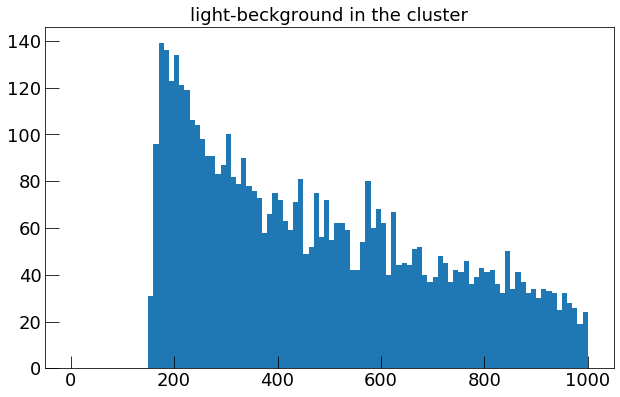

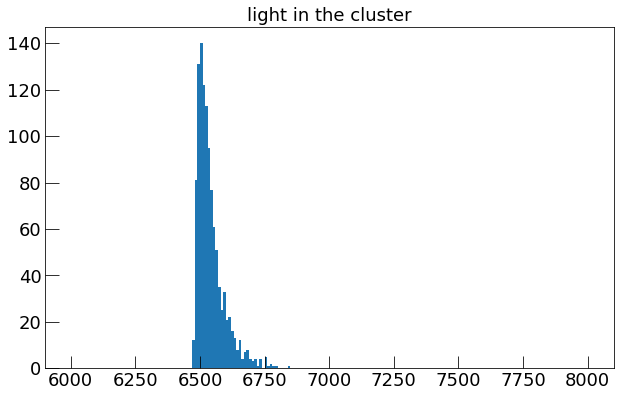

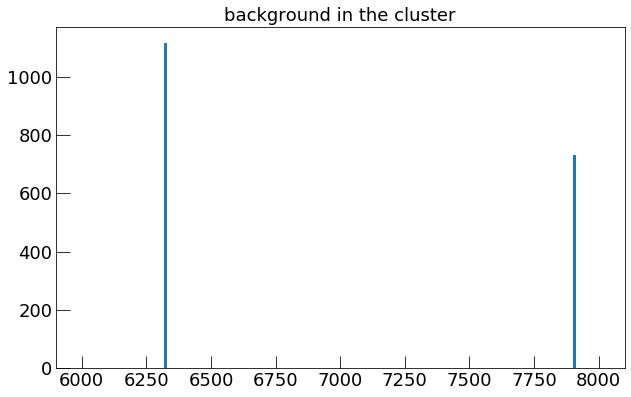

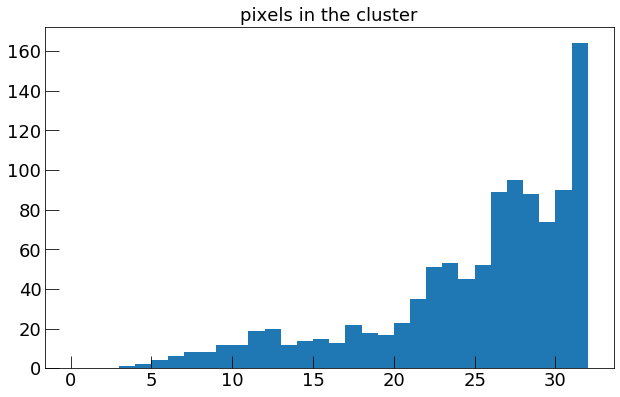

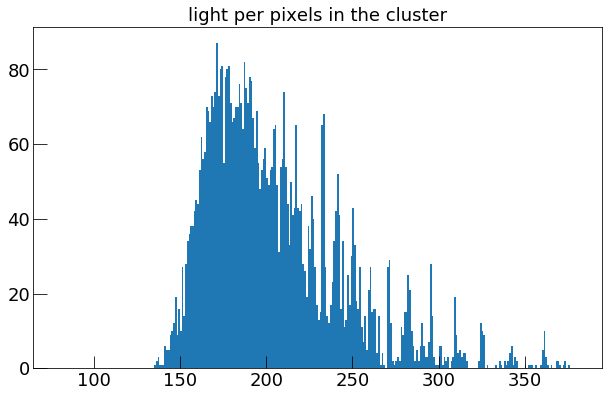

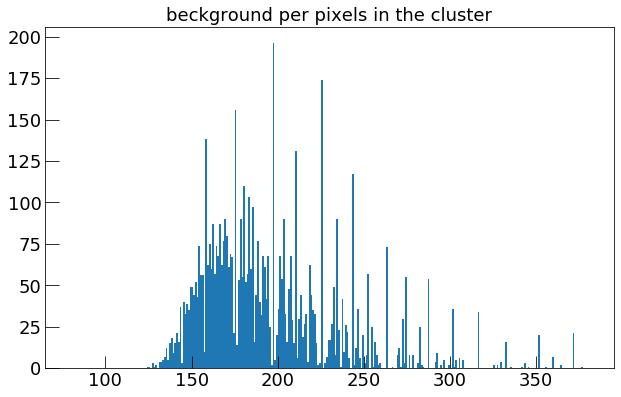

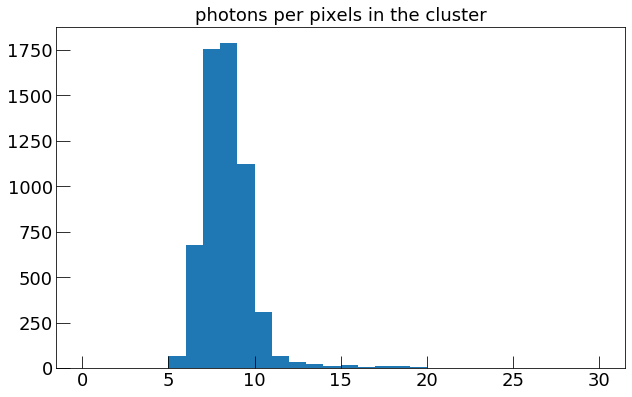

In [8]:
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import scipy.stats as stats
from scipy.stats import norm
cy.set_atlas_style()
y        = np.array(luceB.data[1])
x        = np.array(luceB.data[0])

plt.bar(x,y, 10, align='center')
plt.title("light-beckground in the cluster")
plt.show()
y        = np.array( hL.data[1])
x        = np.array( hL.data[0])

plt.bar(x,y, 10, align='center')
plt.title("light in the cluster")
plt.show()
plt.show()
y        = np.array( hB.data[1])
x        = np.array( hB.data[0])

plt.bar(x,y, 10, align='center')
plt.title("background in the cluster")
plt.show()
y        = np.array( hP.data[1])
x        = np.array( hP.data[0])

plt.bar(x,y, 1, align='center')
plt.title("pixels in the cluster")
plt.show()
y        = np.array( hLP.data[1])
x        = np.array( hLP.data[0])

plt.bar(x,y, 1, align='center')
plt.title("light per pixels in the cluster")
plt.show()
plt.show()
y        = np.array( hBP.data[1])
x        = np.array( hBP.data[0])

plt.bar(x,y, 1, align='center')
plt.title("beckground per pixels in the cluster")
plt.show()

y        = np.array( hLBP.data[1])
x        = np.array( hLBP.data[0])

plt.bar(x,y, 1, align='center')
plt.title("photons per pixels in the cluster")
plt.show()

In [13]:
plt.Circle((x0m, y0m), 5, color='r', fill=False)
plt.show()